# Exam 2021 - December

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from skimage import color, io, morphology
import pandas as pd
import cv2 
from skimage import segmentation, measure
from skimage.filters import median, gaussian, prewitt_h, prewitt_v, prewitt
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2hsv
from scipy.ndimage import correlate
import pydicom as dicom
from skimage.transform import EuclideanTransform, warp,matrix_transform
from scipy.spatial import distance
from scipy.stats import norm
import math

def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()
    
def gamma_map(img_in, gamma):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :param gamma: Exponent
    :return: Gamma-mapped image
    """
    img_float = img_as_float(img_in)
    img_out = np.power(img_float, gamma)
    return img_as_ubyte(img_out)

def histogram_stretch(img_in,max_value, min_value):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = min_value
    max_desired = max_value
	
    # Do something here
    img_out = (((max_desired-min_desired)/(max_val-min_val))*(img_float-min_val))+min_desired

    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)
#example fo how to use min max values for the historgan stretching
#max_value = 231/255
#min_value = 11/255


# Function given from week 11 exercise 6b 
def LDA(X, y):
    """
    Linear Discriminant Analysis.

    A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
    Assumes equal priors among classes

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Training data
    y : array-like of shape (n_samples,)
        Target values.

    Returns
    -------
    W : array-like of shape (n_classes, n_features+1)
        Weights for making the projection. First column is the constants.

    Last modified: 11/11/22, mcbo@dtu.dk
    """
    
    # Determine size of input data
    n, m = X.shape
    # Discover and count unique class labels
    class_label = np.unique(y)
    k = len(class_label)

    # Initialize
    n_group     = np.zeros((k,1))     # Group counts
    group_mean  = np.zeros((k,m))     # Group sample means
    pooled_cov  = np.zeros((m,m))     # Pooled covariance
    W          = np.zeros((k,m+1))    # Model coefficients

    for i in range(k):
        # Establish location and size of each class
        group      = np.squeeze(y == class_label[i])
        n_group[i]  = np.sum(group.astype(np.double))
        
        # Calculate group mean vectors
        group_mean[i,:] = np.mean(X[group,:], axis = 0)
        
        # Accumulate pooled covariance information
        pooled_cov = pooled_cov + ((n_group[i] - 1) / (n - k) ) * np.cov(X[group,:], rowvar = False)
    
    # Assign prior probabilities
    prior_prob = n_group / n

    # Loop over classes to calculate linear discriminant coefficients
    for i in range(k):
        # Intermediate calculation for efficiency
        temp = group_mean[i,:][np.newaxis] @ np.linalg.inv(pooled_cov)
        
        # Constant
        W[i,0] = -0.5 * temp @ group_mean[i,:].T + np.log(prior_prob[i])
        
        # Linear
        W[i,1:] = temp

    return W

## Question 1
An analysis of the nutrients of (N=300) pizzas has been performed and (M=7) values have been measured per pizza (moisture, protein, fat, ash, sodium, carbohydrates, and calories). These measurements can be found in the pizza.txt file. A principal component analysis (PCA) should be done on these data. How many principal components are needed to explain at least 95% of the variation in the data set?

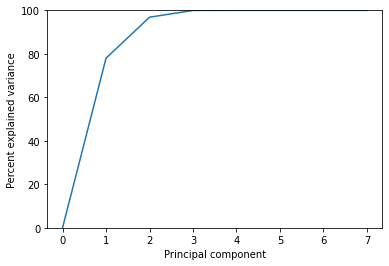

[  0.          78.01010752  96.85076821  99.96408753  99.9982135
  99.99976297  99.99995488 100.        ]


In [2]:
pizza_data = np.loadtxt("Data_2021_Dec/pizza.txt", comments="%")
c_x = np.cov(pizza_data.T)
values, vectors = np.linalg.eig(c_x)
v_norm = values.cumsum() / values.sum() * 100
v_norm = np.insert(v_norm,0,0)
plt.plot(v_norm)
plt.xlabel('Principal component')
plt.ylabel('Percent explained variance')
plt.ylim([0, 100])
plt.show()
print(v_norm)

#We need 2 PC's in order to explain 95% of the variation in the data set

## Question 2
An analysis of the nutrients of (N=300) pizzas has been performed and (M=7) values have been measured per pizza (moisture, protein, fat, ash, sodium, carbohydrates, and calories). These measurements can be found in the pizza.txt file. A principal component analysis (PCA) should be done on these data. The nutrients of a new pizza are computed by adding 3 times the first principal component to the mean nutrient values. What is the moisture level of this new pizza?

In [3]:
mean = np.mean(pizza_data, axis=0)
pc1 = vectors[0]
print("New moisture level:", mean[0]+3*pc1[0])

New moisture level: 41.73395694605246


## Question 3 
Six photos have been taken. They are named orchid001.png - orchid006.png. The dimensions of each photo are (W=400, H=533 pixels). In order to do some statistical analysis of the images, the average image of the six photos is computed. Finally, a threshold of 150 is applied to the average image so pixels above the threshold are considered as foreground and the rest as background. Which is the resulting image?

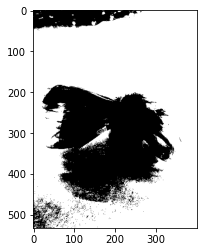

In [4]:
H = 533
W = 400
M = H * W
amount_of_img = 6
orchid1 = io.imread("Data_2021_Dec/Orchid1-6/orchid001.png")
orchid2 = io.imread("Data_2021_Dec/Orchid1-6/orchid002.png")
orchid3 = io.imread("Data_2021_Dec/Orchid1-6/orchid003.png")
orchid4 = io.imread("Data_2021_Dec/Orchid1-6/orchid004.png")
orchid5 = io.imread("Data_2021_Dec/Orchid1-6/orchid005.png")
orchid6 = io.imread("Data_2021_Dec/Orchid1-6/orchid006.png")
#initialize the overall data matrix
data_overall = np.zeros([M, amount_of_img])
data_overall[:,0] =np.reshape(orchid1, newshape=M)
data_overall[:,1] =np.reshape(orchid2, newshape=M)
data_overall[:,2] =np.reshape(orchid3, newshape=M)
data_overall[:,3] =np.reshape(orchid4, newshape=M)
data_overall[:,4] =np.reshape(orchid5, newshape=M)
data_overall[:,5] =np.reshape(orchid6, newshape=M)

mean = data_overall.mean(axis = 1)
mean = mean.reshape(H,W)
mean.shape

threshold = 150
threshold_img = mean > threshold
fig, ax = plt.subplots()
plt.imshow(threshold_img, cmap="gray")
#Option E

## Question 4+5 are made for matlab - therefore no answer 

## Question 6 
A photo containing bikes has been taken (bikes.png). An RGB treshold is
applied to this photo, so pixels within the limits R < 100, G > 200 and B > 100 are set to foreground (1) and the rest of the pixels are set to background (0). The resulting binary image is morphologically closed using a diskshaped structuring element with radius = 8. When doing the closing, the pixels beyond the image border are assigned a value of 0 for the dilation and 1 for the erosion (the default Matlab behavior). How does the resulting binary image look like?


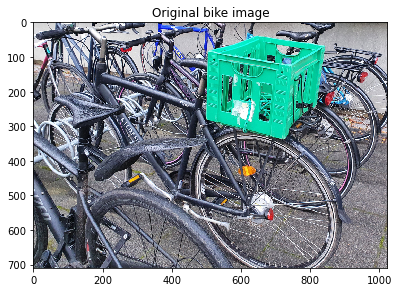

(710, 1024, 3)
1024


In [5]:
bikes_org = io.imread("Data_2021_Dec/BikeImage/bikes.png")
io.imshow(bikes_org)
plt.title("Original bike image")
io.show()
print(bikes_org.shape)
print(bikes_org.shape[1])

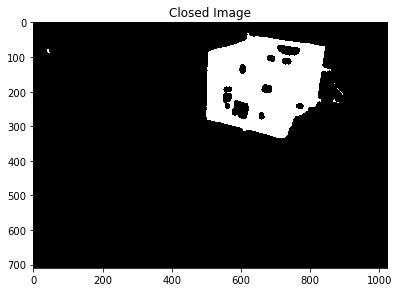

In [6]:
RGBthreshold = bikes_org.copy()
# seperate the rgb
r_com = RGBthreshold[:,:,0]
g_com = RGBthreshold[:,:,1]
b_com = RGBthreshold[:,:,2]
segm = (g_com > 200) & (r_com < 100) & (b_com > 100) #add the threshold
#io.imshow(segm)
#plt.title("Binary Image before ")
#io.show()
# disk of 8 from the question 
disk = morphology.disk(8)
closed = morphology.closing(segm, disk)
io.imshow(closed)
plt.title("Closed Image")
io.show()

## Question 7
A friend has asked you to make a system, that can identify climbing holds on photos from the friend's climbing gym. A photo of a climbing wall (ClimbingWall.png) is provided. Your system initially computes a binary image by applying an RGB threshold where pixels with R < 60, G < 200, and B < 100 are set to foreground (1) and the rest of the pixels are set to background (0).

Secondly, a morphological closing with a disk-shaped structuring element with radius = 3 is performed. When doing a dilation, pixels beyond the image border are assigned a value of 0 and when doing an erosion the pixels beyond the image border are assigned a value of 1 (the default Matlab behavior).

After this, all BLOBs that are connected to the image border are removed.

Finally, all BLOBs in the image are found using 8-connectivity. How many BLOBs are found?


In [7]:
climbing = io.imread("Data_2021_Dec/Climbing/ClimbingWall.png")
#io.imshow(climbing)
#plt.title("Original climbing image")
#io.show()
#print(climbing.shape)

r_com_clim = climbing[:,:,0]
g_com_clim = climbing[:,:,1]
b_com_clim = climbing[:,:,2]
segm_clim = (g_com_clim < 200) & (r_com_clim < 60) & (b_com_clim < 100) #add the threshold
#io.imshow(segm_clim)
#plt.title("Binary Climing images")
#io.show()

disk_clim = morphology.disk(3)
closed_clim = morphology.closing(segm_clim, disk_clim)
#io.imshow(closed_clim)
#plt.title("Closed Image of Climing wall")
#io.show()

#clear boarder
climbing_c_b = segmentation.clear_border(closed_clim)
#io.imshow(climbing_c_b)
#plt.title("Cleared boarder")
#io.show()

#missing the 8 connectivity 


label_img = measure.label(climbing_c_b, connectivity=2) #with res_img the solution is 493
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")


#when 8-connectivity is applied the amount of blobs will decrease in some will be consideren 1 blob insterad of multiple 
#Correct Answer is 536

Number of labels: 566


## Question 8 
A friend has asked you to make a system, that can identify climbing holds on photos from the friend's climbing gym. A photo of a climbing wall (ClimbingWall.png) is provided. Your system initially computes a binary image by applying a RGB threshold where pixels with R < 60, G < 200, and B < 100 are set to foreground (1) and the rest of the pixels are set to background (0).

Secondly, a morphological closing with a disk-shaped structuring element with radius = 3 is performed. When doing a dilation, pixels beyond the image border are assigned a value of 0 and when doing an erosion the pixels beyond the image border are assigned a value of 1 (the default Matlab behavior).

After this, all BLOBs that are connected to the image border are removed.
All BLOBs in the image are found using 8-connectivity. 

The area and the perimeter of the found BLOBs are computed and only the BLOBs with an area larger than 300 pixels and with a perimeter less than 500 are kept. How many BLOBs are there in the final image?


In [8]:
region_props = measure.regionprops(label_img)
min_area = 300
max_perimeter = 500
j = 0
for i in range(n_labels):
    if region_props[i].area > min_area and region_props[i].perimeter < max_perimeter:
        #print("Area", region_props[i].area)
        #print("Perimeter", region_props[i].perimeter)
        j = j + 1
print("Amount of Blob's that are with in those intervals:", j)

# Answer is 20 but still without the 8-connectivity

Amount of Blob's that are with in those intervals: 20


## Question 9 
The photo called bird.png is converted from the RGB color space to the HSV color space. A new image is created by copying only the S component of the input image. The new image is then filtered with a vertical Prewitt filter (the default Matlab fspecial Prewitt filter) using border replication. The filtered image looks like this (you can use imshow(I, []) to show an image called I):


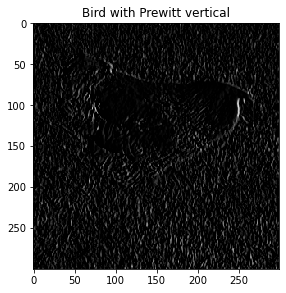

In [9]:
bird = io.imread("Data_2021_Dec/Bird/bird.png")
#io.imshow(bird)
#plt.title("Original bird image")
#io.show()
#print(bird.shape)

#convert to hsv image 
bird_hsv = rgb2hsv(bird)
#io.imshow(bird_hsv)
#plt.title("HSV image")
#io.show()

#We keep only the s component
s_com = bird_hsv[:,:,1]
#print(s_com)

bird_prewitt_v = prewitt_v(s_com)
io.imshow(img_as_ubyte(bird_prewitt_v))
plt.title('Bird with Prewitt vertical')
io.show()


## Question 10
The photo called water_gray.png is filtered using a 3x3 median filter. A linear histogram stretching is then performed on the filtered image so the new image has a maximum pixel value of 230 and a minimum pixel value of 12. What is the pixel value at (row=20, column=20) in the new image (a 1-based matrix coordinate system is used)?


In [10]:
water = io.imread("Data_2021_Dec/Water/water_gray.png")
#io.imshow(water)
#plt.title("Original water image")
#io.show()

size = 3
footprint = np.ones([size, size])
med_water = median(water, footprint)
#io.imshow(med_water)
#plt.title("Water with 3x3 median filer")
#io.show()
def histogram_stretch(img_in,max_value, min_value):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = min_value
    max_desired = max_value
	
    # Do something here
    img_out = (((max_desired-min_desired)/(max_val-min_val))*(img_float-min_val))+min_desired

    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)

max_value = 231/255
min_value = 11/255

water_stretched = histogram_stretch(med_water,max_value, min_value)
print("Value at 20,20:", water_stretched[19,19])


Value at 20,20: 217


## Question 11 
A scan has been done on a CT scanner and stored as a DICOM file. One of the slices of the scan is stored as a DICOM file called 1-131.dcm. Expert annotations of the liver (LiverROI.png), the spleen (SpleenROI.png), and bone (BoneROI.png) are also provided. By using the DICOM image and the mask images, gray-values representing the liver, the spleen, and the bone can be extracted.

The goal is to develop a minimum distance classifier based on the annotated data. What will be the gray-value range of the spleen?

In [11]:
# first we read the dicom file
in_dir = "Data_2021_Dec/DICOM/"
im_name = "1-131.dcm"
ds = dicom.dcmread(in_dir + im_name)
im = ds.pixel_array #type = unit 16
img = im.astype(float) #convert to float 

#how we convert [-1024,1024] to [0,255]
norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = norm_image.astype(np.uint8)

# plots of the differnt levels 
# io.imshow(img)
# plt.title("Dicom image in -1024-1024 scale")
# io.show()

# io.imshow(norm_image)
# plt.title("Dicom image in 0-255 scale")
# io.show()

# plt.figure()
# plt.imshow(img, cmap='gray', vmin=-200, vmax=200)
# plt.colorbar()
# plt.show()


bone_roi = io.imread(in_dir + 'BoneROI.png')
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
liver_roi = io.imread(in_dir + "LiverROI.png")
# get values
bone_mask, liver_mask, spleen_mask = bone_roi > 0, liver_roi > 0, spleen_roi > 0
bone_values, liver_values, spleen_values = img[bone_mask], img[liver_mask], img[spleen_mask]
#bone_values, liver_values, spleen_values = norm_image[bone_mask], norm_image[liver_mask], norm_image[spleen_mask]
# compute mean and std 
mu_bone, mu_liver, mu_spleen = np.mean(bone_values), np.mean(liver_values), np.mean(spleen_values)

print("Bone mean:",mu_bone)
print("Liver mean:",mu_liver)
print("Spleen mean:",mu_spleen)

#Finding the range for the spleen
j = [0]
for i in range(800):
    if abs(i-mu_liver) < abs(i-mu_spleen):
        j.append(1)
        if j[i] != j[i-1]:
            print("Will be classified as liver. I-Value:", i)
    elif abs(i-mu_spleen) < abs(i - mu_bone):
        j.append(2)
        if j[i] != j[i-1]:
            print("Change between Liver and spleen classification", i-1)
    elif abs(i-mu_spleen) > abs(i - mu_bone):
        j.append(3)
        if j[i] != j[i-1]:
            print("Change between Spleen and Bone classification", i-1)
            
#Interval for spleen will be [99,482]

Bone mean: 838.4418604651163
Liver mean: 73.28221208665906
Spleen mean: 124.72452830188679
Will be classified as liver. I-Value: 0
Will be classified as liver. I-Value: 1
Change between Liver and spleen classification 100
Change between Spleen and Bone classification 482


## Question 11 
A scan has been done on a CT scanner and stored as a DICOM file. One of the slices of the scan is stored as a DICOM file called 1-131.dcm. A low threshold, T1=85, and a high threshold, T2=400, are defined. The scan is segmented by setting pixels with values that are higher than T1 and lower than T2 to foreground (1) and the rest of the pixels to background (0).

A morphological closing with a disk-shaped structuring element with radius=5 is performed on the binary image, followed by a morphological opening with a disk-shaped structuring element with radius=3. When doing a dilation, pixels beyond the image border are assigned a value of 0 and when doing an erosion the pixels beyond the image border are assigned a value of 1 (the default Matlab behavior).

A BLOB analysis is then performed using 8-connectivity and only BLOBs with an area between 1000 and 4000 pixels are kept. How many BLOBs are there in the final image?

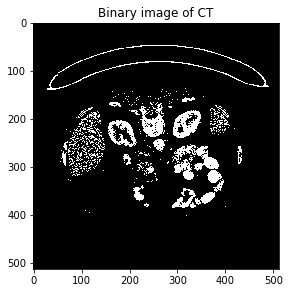

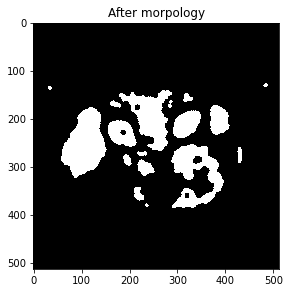

Number of labels: 17
Amount of Blob's that are with in those intervals: 3


In [12]:
#Create the binary image from the treshold given
bin_img = (im < 400) & (im > 85)
io.imshow(bin_img)
plt.title("Binary image of CT")
io.show()

closed = morphology.closing(bin_img, morphology.disk(5))
opened = morphology.opening(closed, morphology.disk(3))

io.imshow(opened)
plt.title("After morpology")
io.show()

#finding amount of blobs in the opende image
label_img = measure.label(opened, connectivity=2) #with res_img the solution is 493
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

region_props = measure.regionprops(label_img)
min_area = 1000
max_area = 4000
j = 0
for i in range(n_labels):
    if region_props[i].area > min_area and region_props[i].area < max_area:
        #print("Area", region_props[i].area)
        #print("Perimeter", region_props[i].perimeter)
        j = j + 1
print("Amount of Blob's that are with in those intervals:", j)

## Question 12
Two similar images have been acquired (donald_1.png and donald_2.png). Six corresponding landmarks have been placed on the two images and are stored in the files donaldfixedPoints.mat and donaldmovingPoints.mat.

The center of mass (the average landmark position) has been computed for both sets of points. What is the Euclidean distance between these two center of masses?

A similarity transform (translation, rotation, and scaling) has been performed that aligns the moving points to the fixed points. The computed transform is applied to the donald_2.png photo. What is the RGB value at position (row=300, column=300, in a 1-based matrix coordinate system) in the transformed image?

x_fixed: 234.5533333333333, y_fixed: 255.72500000000002, x_moving: 240.31833333333336, y_moving: 258.5366666666667
6.414101218755824


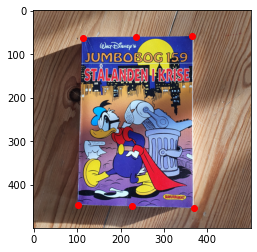

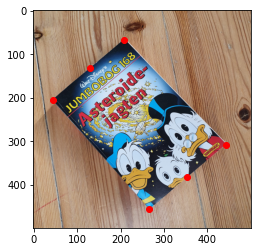

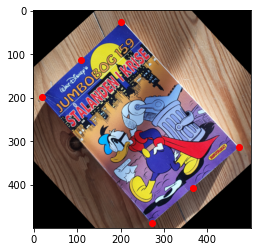

(500, 500, 3)
float64
1.0
0.0
R: 190.61284639095544, G: 33.96678444077249, B: 49.18959207818668


In [13]:
fixed_img = io.imread('Data_2021_Dec/Donald/donald_1.png')
moving_img = io.imread('Data_2021_Dec/Donald/donald_2.png')

fixed_points = np.array([[363.44, 58.78], [235.63,60.39], [112.62,63.60], 
                         [101.38,447.04], [225.98,450.26], [368.27,454.28]])
moving_points = np.array([[208.30,66.82], [129.52,131.13], [45.11,206.69], 
                         [265.37,455.89], [352.19,382.73], [441.42,307.96]])

#We first find the euclidean distance 
x_fixed = np.mean(fixed_points[:,0])
y_fixed = np.mean(fixed_points[:,1])
x_moving =np.mean(moving_points[:,0])
y_moving =np.mean(moving_points[:,1])
print(f'x_fixed: {x_fixed}, y_fixed: {y_fixed}, x_moving: {x_moving}, y_moving: {y_moving}')
euclidian_distance = np.sqrt(np.power((x_fixed-x_moving),2)+np.power((y_fixed-y_moving),2))
print(euclidian_distance)


plt.imshow(fixed_img)
plt.plot(fixed_points[:, 0], fixed_points[:, 1], '.r', markersize=12)
plt.show()

plt.imshow(moving_img)
plt.plot(moving_points[:, 0], moving_points[:, 1], '.r', markersize=12)
plt.show()

#We create the transformations here
tform = EuclideanTransform()
tform.estimate(fixed_points, moving_points)
#Transform the points
transform = matrix_transform(fixed_points, tform.params)
# Transform the images
warped = warp(fixed_img, tform.inverse)
#Plot the transformed images and points
plt.imshow(warped)
plt.plot(transform[:, 0], transform[:, 1], '.r', markersize=12)
plt.show()

print(warped.shape)
print(warped.dtype)
print(np.max(warped))
print(np.min(warped))

r_value = warped[300,300,0]*255
g_value = warped[300,300,1]*255
b_value = warped[300,300,2]*255
#image = (image * 255).round().astype(np.uint8)
print(f'R: {r_value}, G: {g_value}, B: {b_value}')

## Question 13
A customer has asked you to design a prototype system for the inspection of children's plastic balls. You are setting up a camera with a CCD ship that measures 5.4 x 4.2 mm and that has a focal length of f=15 mm. It can be assumed that b=f. The photos from the camera have dimensions 6480 x 5040 pixels. The camera is placed 1.5 meter from the ball, where the photos of the balls passing by are sharp. An example ball has been tested and the diameter of the ball is 2400 pixels on the photo.

What is the physical diameter of the ball?

In [14]:
g = 1.5 #in meters 
b = 0.015 #in meters 
number_of_width_pixels = 6480
number_of_height_pixels = 5040

cw = 0.0054 #chip width in meters
ch = 0.0042 #chip heigh in meters

pixel_width_per_meter_widht = number_of_width_pixels/(cw*1000)
pixel_height_per_meter_height = number_of_height_pixels/(ch*1000)
print(pixel_width_per_meter_widht)
# cwp = cw * 1200 * 1000 # Don't know where 1200 x 1000 comes from 
# cwh = ch * 1200 * 1000 # Don't know where 1200 x 1000 comes from 

# pw = cw/cwp #pixel width meters 
pw = 1/(1200 * 1000)
p = 2400 #amount of ball pixels
B = p*pw
G = B*g/b

print(G)

1200.0
0.2


## Question 14 
A photo containing bikes has been taken (bikes.png). An RGB treshold is applied to this photo, so pixels within the limits R < 100, G > 200 and B > 100 are set to foreground (1) and the rest of the pixels are set to background (0). 

The resulting binary image is morphologically closed using a diskshaped structuring element with radius = 8. When doing the closing, the pixels beyond the image border are assigned a value of 0 for the dilation and 1 for the erosion (the default Matlab behavior).

A ground truth segmentation is provided in the file boxROI.png. What is the DICE score between your segmentation and the ground truth segmentation?

In [15]:
bikes_org = io.imread("Data_2021_Dec/BikeImage/bikes.png")
RGBthreshold = bikes_org
# seperate the rgb
r_com = RGBthreshold[:,:,0]
g_com = RGBthreshold[:,:,1]
b_com = RGBthreshold[:,:,2]
segm = (g_com > 200) & (r_com < 100) & (b_com > 100)
disk = morphology.disk(8)
closed = morphology.closing(segm, disk)

gt_1 = (io.imread("Data_2021_Dec/BikeImage/boxROI.png") > 0)

dice_score = 1 - distance.dice(closed.ravel(), gt_1.ravel())
print(f'Dice score is: {dice_score}')

Dice score is: 0.9314763598050836


## Question 15 
You have been asked to design a vision system for a self-driving robot. The first system should be able to classify grass, road, and sky and is using a gray level camera (where a pixel value of 0 is black and 255 is white). For training, you have received the following gray values:

Grass: 68, 65, 67

Road: 70, 80, 75

Sky: 77, 92, 89

For a minimum distance classifier, your gray level class ranges would be?

In [16]:
mu_grass = np.mean(np.array([68,65,67]))
mu_road = np.mean(np.array([70,80,75]))
mu_sky = np.mean(np.array([77,92,89]))
print(mu_grass)
print(mu_road)
print(mu_sky)

j = [1]
for i in range(85):
    if abs(i-mu_grass) < abs(i-mu_road):
        j.append(1)
        if j[i] != j[i-1]:
            print("Will be classified as grass. I-Value:", i)
    elif abs(i-mu_road) < abs(i - mu_sky):
        j.append(2)
        if j[i] != j[i-1]:
            print("Change between grass and road classification", i-1)
    elif abs(i-mu_road) > abs(i - mu_sky):
        j.append(3)
        if j[i] != j[i-1]:
            print("Change between road and sky classification", i-1)
            
print(f"Grass boarder: [0,{np.round((mu_grass + mu_road)/2)}]")
print(f"Road boarder: [{np.round((mu_grass + mu_road)/2)},{(mu_sky + mu_road)/2}]")
print(f"Grass boarder: [{((mu_sky + mu_road)/2)},255]")

66.66666666666667
75.0
86.0
Change between grass and road classification 71
Change between road and sky classification 81
Grass boarder: [0,71.0]
Road boarder: [71.0,80.5]
Grass boarder: [80.5,255]


## Question 16
You have been asked to design a vision system for a self-driving robot. The first system should be able to classify grass, road, and sky and is using a gray level camera (where a pixel value of 0 is black and 255 is white). For training, you have received the following gray values:

Grass: 68, 65, 67

Road: 70, 80, 75

Sky: 77, 92, 89

For a parametric classifier, your gray level class ranges would be?

In [17]:

grass = np.array([68,65,67])
road = np.array([70,80,75])
sky = np.array([77,92,89])

mu_grass = np.mean(grass)
mu_road = np.mean(road)
mu_sky = np.mean(sky)
std_grass = np.std(grass)
std_road = np.std(road)
std_sky = np.std(sky)
print(f'grass {std_grass}, road {std_road}, sky {std_sky}')

#Solved the rest in maple by creating 3 gaussian equation (1 for each variable)
# Then set the two equation equal to each other and solved for x 


grass 1.247219128924647, road 4.08248290463863, sky 6.48074069840786


## Question 17
A path tracing using dynamic programming has been used to compute the optimal path from the top to the bottom of the image seen below. A 1-based Matrix coordinate system is used. What is the value of the backtracing image at position (row=5, column=3)?

In [18]:
# Followe process on slide 496 and forward
# Answer is 4

## Question 18 
A vision system to classify two plant species as seen from a farming machine should be developed. What could be the main components in this system?

In [19]:
# RGB camera, RGB tresholding, BLOB analysis, linear discriminant analysis (LDA) of BLOB features.

# December 2020

The irisdata.txt file contains measurements from 150 iris flowers. The measurements are the sepal length, sepal width, petal length and petal width. So you have M=4 features, N=150 observations. A principal component analysis (PCA) should be done on these data. How many percent of the total variation do the two first principal components explain?

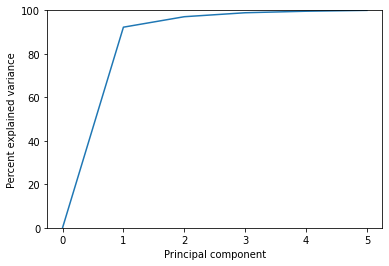

[  0.          92.26437296  97.07713642  98.90359077  99.6025738
 100.        ]


In [72]:
iris_data = np.loadtxt("Data_2021_May/irisdata.txt", comments="%")
# splitting the data to only contain the data and not the classes
# M = iris_data[:,0:4]
# print(M)
# print(np.mean(M))
# print(M-np.mean(M))
c_x = np.cov(iris_data.T)
values, vectors = np.linalg.eig(c_x)
# PC, V = np.linalg.eig(c_x)
# # print(PC)
v_norm = values.cumsum() / values.sum() * 100
v_norm = np.insert(v_norm,0,0)
plt.plot(v_norm)
plt.xlabel('Principal component')
plt.ylabel('Percent explained variance')
plt.ylim([0, 100])
plt.show()
print(v_norm)

#2 principle componetns give us 97.7% 

The irisdata.txt file contains measurements from 150 iris flowers. The measurements are the sepal length, sepal width, petal length, and petal width. So you have M=4 features, N=150 observations. A principal component analysis (PCA) should be done on these data.

After the PCA, the flower data (sepal lengths and widths, petal lengths and widths) are projected into PCA space. What are the projected values of the first flower?

In [21]:
pc1 = vectors
print(pc1)

[[-0.33402494  0.68852577  0.44147762  0.43312829 -0.17848527]
 [ 0.08034626  0.68474905 -0.61141397 -0.30348725  0.24234615]
 [-0.80059273 -0.09713877  0.14667872 -0.49080356  0.29531771]
 [-0.33657862 -0.06894557 -0.42020248 -0.06667133 -0.83722527]
 [-0.35740442 -0.20703034 -0.48289304  0.68917499  0.34821352]]


The photo called sky_gray.png is loaded and a linear histogram stretching is performed so the new image has a maximum pixel value of 200 and a minimum pixel value of 10. What is the average pixel value of the new image?

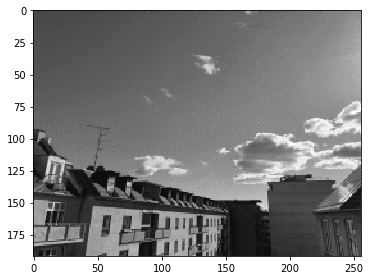

Current Max: 251, Currect Min: 13
New Max: 200, New Min: 10
Average pixel of stretched 86.9539794921875


In [22]:
sky_gray = io.imread('Data_2021_May/sky_gray.png')
io.imshow(sky_gray)
io.show()
current_min = np.min(sky_gray)
current_max = np.max(sky_gray)
print(f'Current Max: {current_max}, Currect Min: {current_min}')

#We perform a stretch of the historgam, 
def histogram_stretch(img_in,max_value, min_value):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = min_value
    max_desired = max_value
	
    # Do something here
    img_out = (((max_desired-min_desired)/(max_val-min_val))*(img_float-min_val))+min_desired

    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)

max_value = 200/255
min_value = 10/255

sky_stretched = histogram_stretch(sky_gray,max_value, min_value)
new_min = np.min(sky_stretched)
new_max = np.max(sky_stretched)
print(f'New Max: {new_max}, New Min: {new_min}')
print(f'Average pixel of stretched {np.mean(sky_stretched)}')

The photo called sky.png is loaded and an RGB threshold is performed with the limits R < 100, G > 85, G < 200, and B > 150. Pixels with values within these limits are set to foreground and the rest of the pixels are set to background. The resulting 2D binary image is morphologically eroded using a disk-shaped structuring element with radius=5. When doing an erosion the pixels beyond the image border are assigned a value of 1.

How many foreground pixels are there in the final image?

(192, 256, 3)
(192, 256)


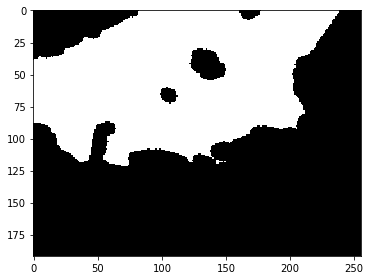

amount of pixels in the forground: 19613


In [73]:
sky = io.imread('Data_2021_May/sky.png')
print(sky.shape)
r_com_sky = sky[:,:,0]
g_com_sky = sky[:,:,1]
b_com_sky = sky[:,:,2]
segm_sky = (r_com_sky < 100) & (g_com_sky > 85) & (g_com_sky < 200) & (b_com_sky > 150) #add the threshold

sky_eroded = morphology.erosion(segm_sky, morphology.disk(5))
print(sky_eroded.shape)
io.imshow(sky_eroded)
io.show()          
print(f'amount of pixels in the forground: {np.sum(sky_eroded)}')

The photo called flower.png is loaded and it is converted from the RGB color space to the HSV color space. Secondly, a threshold is performed on the HSV values with the limits H < 0.25, S > 0.8 and V > 0.8. Pixels with values within these limits are set to foreground and the rest of the pixels are set to background. Finally, a morphological opening is performed on the binary image using a diskshaped structuring element with radius=5. When doing a dilation, pixels beyond the image border are assigned a value of 0 and when doing an erosion the pixels beyond the image border are assigned a value of 1 (the default Matlab behavior).

What is the number of foreground pixels in the resulting image?

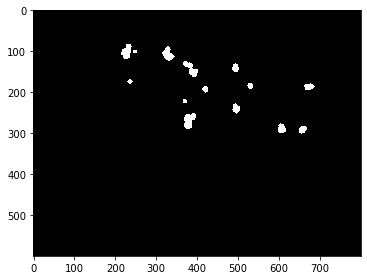

amount of pixels in the forground: 4948


In [74]:
flower = io.imread("Data_2021_May/flower.png")
#convert to hsv image 
flower_hsv = rgb2hsv(flower)

#Segment the differnt colours
h_com = flower_hsv[:,:,0]
s_com = flower_hsv[:,:,1]
v_com = flower_hsv[:,:,2]

flower_seg = (h_com < 0.25) & (s_com > 0.8) & (v_com > 0.8)
flower_opening = morphology.opening(flower_seg, morphology.disk(5))

io.imshow(flower_opening)
io.show()            
print(f'amount of pixels in the forground: {np.sum(flower_opening)}')

The photo called sky_gray.png is transformed using a gamma mapping with gamma=1.21. The output image is filtered using a 5x5 median filter. What is the resulting pixel value in the pixel at row=40, column=50 (when using a 1-based matrixbased coordinate system)?

In [25]:
sky_gray = io.imread("Data_2021_May/sky_gray.png")
sky_gamma = gamma_map(sky_gray, 1.21)
sky_median = median(sky_gamma, np.ones([5, 5]))
print(f'Pixel value at 40,50: {sky_median[40,50]}')

Pixel value at 40,50: 68


The photo called flowerwall.png is filtered using an average filter with a filter size of 15. The filtering is performed with border replication. What is the resulting pixel value in the pixel at row=5 and column=50 (when using a 1-based matrix-based coordinate system)?

In [31]:
flowerwall = io.imread("Data_2021_May/flowerwall.png")
flowerwall_median = median(flowerwall, np.ones([15, 15]))
print(f'Value at 5,50: {flowerwall_median[5,50]}')

Value at 5,50: 209


A photo has been taken of a set of floorboards (floorboards.png) and the goal is to measure the amounts of knots in the wood. First, a threshold of 100 is used, so pixels below the threshold are set to foreground and the rest is set to background. To remove noise a morphological closing is performed with a disk-shaped structuring element with radius=10 followed by a morphological opening with a disk-shaped structuring element with radius=3. When doing a dilation, pixels beyond the image border are assigned a value of 0 and when doing an erosion the pixels beyond the image border are assigned a value of 1 (the default Matlab behavior). Finally, all BLOBs that are connected to the image border are removed. 

How many foreground pixels are remaining in the image?

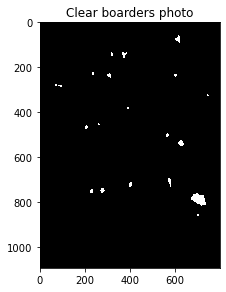

amount of pixels in the forground: 6491


In [27]:
floorboards = io.imread("Data_2021_May/floorboards.png")
floorboards_binary = floorboards < 100
floorboards_closing = morphology.closing(floorboards_binary, morphology.disk(10))
floorboards_opening = morphology.opening(floorboards_closing, morphology.disk(3))
floorboards_c_b = segmentation.clear_border(floorboards_opening)

io.imshow(floorboards_c_b)
plt.title("Clear boarders photo")
io.show()


print(f'amount of pixels in the forground: {np.sum(floorboards_c_b)}')

A photo has been taken of a set of floorboards (floorboards.png) and the goal is to measure the amounts of knots in the wood. First, a threshold of 100 is used, so pixels below the threshold are set to foreground and the rest is set to background. To remove noise a morphological closing is performed with a disk-shaped structuring element with radius=10 followed by a morphological opening with a disk-shaped structuring element with radius=3. When doing a dilation, pixels beyond the image border are assigned a value of 0 and when doing an erosion the pixels beyond the image border are assigned a value of 1 (the default Matlab behavior). A BLOB analysis is performed where all BLOBS are found using 8-connectivity. All BLOBs that are connected to the image border are removed. The area of the found BLOBs are computed and only the BLOBs with an area larger than 100 pixels are kept. 

How many BLOBs are found in the final image?

In [28]:
#finding amount of blobs in the image
label_img = measure.label(floorboards_c_b, connectivity=2) #with res_img the solution is 493
n_labels = label_img.max()
# print(f"Number of labels: {n_labels}")

region_props = measure.regionprops(label_img)
min_area = 100
# max_area = 4000

j = 0
for i in range(n_labels):
    if region_props[i].area > min_area:
        #print("Area", region_props[i].area)
        #print("Perimeter", region_props[i].perimeter)
        j = j + 1
print("Amount of Blob's that are with in those intervals:", j)

Amount of Blob's that are with in those intervals: 16


The binary image books_bw.png contains letters. A BLOB analysis is performed using 8-connectivity. For each BLOB, the area and the perimeter is computed. The BLOBs with area > 100 and perimeter > 500 are kept. 

Which letters are visible in the final image?

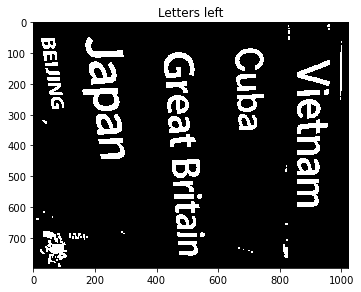

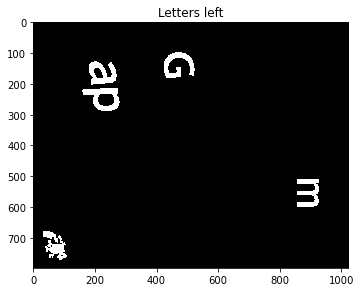

In [88]:
books_bw = io.imread("Data_2021_May/books_bw.png")
label_img = measure.label(books_bw, connectivity=2)
n_labels = label_img.max()
# print(f"Number of labels: {n_labels}")

io.imshow(books_bw)
plt.title('Letters left')
io.show()

region_props = measure.regionprops(label_img)
min_area = 100
min_perimeter = 500


# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.perimeter < min_perimeter or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0

io.imshow(i_area)
plt.title('Letters left')
io.show()

Seven corresponding landmarks have been placed on two images (cat1.png and cat2.png). The landmarks are stored in the files catfixedPoints.mat and catmovingPoints.mat. 

What is the sum of squared differences between the fixed and the moving landmarks?

In [30]:
fixed_points = np.array([[297.75,88.25],[333.25,341.75],[499.75,466.75],[661.25,347.25],
                         [685.25,87.25],[564.75,140.75],[436.25,152.75]])
moving_points = np.array([[335.375,41.625],[378.375,241.625],[502.875,348.125],[652.625,255.875],
                         [697.125,44.125],[594.875,96.875],[439.125,93.125]])
#We have to find the sum of square differences 
ssd = np.sum(np.sum(np.power((fixed_points-moving_points),2)))
print(f'The sum of squared differnce between the differnt landmarks are: {ssd}')


The sum of squared differnce between the differnt landmarks are: 46552.96875


Seven corresponding landmarks have been placed on two images (cat1.png and cat2.png). The landmarks are stored in the files catfixedPoints.mat and catmovingPoints.mat. A similarity transform (translation, rotation, and scaling) has been performed that aligns the moving points to the fixed points. The computed transform is applied to the cat2.png photo. 

How does the resulting image look like?

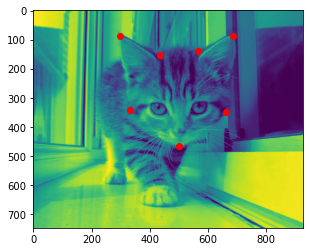

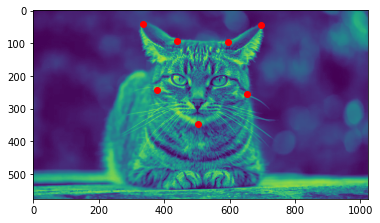

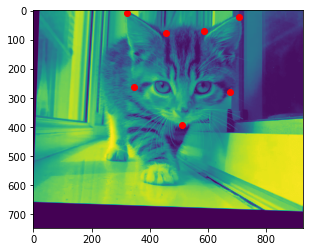

In [31]:
cat1 = io.imread("Data_2021_May/cat1.png")
cat2 = io.imread("Data_2021_May/cat2.png")
fixed_img = cat2
moving_img = cat1

plt.imshow(cat2)
plt.plot(fixed_points[:, 0], fixed_points[:, 1], '.r', markersize=12)
plt.show()

plt.imshow(cat1)
plt.plot(moving_points[:, 0], moving_points[:, 1], '.r', markersize=12)
plt.show()

#We create the transformations here
tform = EuclideanTransform()
tform.estimate(fixed_points, moving_points)
#Transform the points
transform = matrix_transform(fixed_points, tform.params)
# Transform the images
warped = warp(fixed_img, tform.inverse)
#Plot the transformed images and points
plt.imshow(warped)
plt.plot(transform[:, 0], transform[:, 1], '.r', markersize=12)
plt.show()

An abdominal scan has been acquired on a CT scanner. One of the slices of the scan is stored as a DICOM file called 1-179.dcm. An expert has marked a part of the liver as a binary mask (region of interest). The binary mask is stored as the file LiverROI.png. By using the DICOM image and the mask image, the image values in the DICOM image inside the mask (the liver) can be extracted.

The average value and the standard deviation of the extracted pixel values are computed. A low threshold, T1, is defined as the average value minus the standard deviation and a high threshold, T2, is defined as the average value plus the standard deviation.

Finally, a segmentation of the DICOM image (1-179.dcm) is made where all pixels with values > T1 and < T2 are set to foreground and the rest are set to background. How many foreground pixels are there?

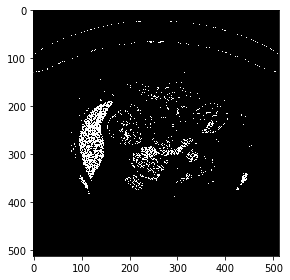

 Amount of for ground pixels 8984


In [85]:
in_dir = "Data_2021_May/"
im_name = "1-179.dcm"
ds = dicom.dcmread(in_dir + im_name)
img = ds.pixel_array
liver_roi = io.imread(in_dir + 'LiverROI.png')
print
# get values
liver_mask =  liver_roi > 0
liver_values = img[liver_mask]
# compute mean and std 
mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)

min_threshold = mu_liver - std_liver
max_threshold = mu_liver + std_liver 

liver_img = (img < max_threshold) & (img > min_threshold)
io.imshow(liver_img)
io.show()

print(f' Amount of for ground pixels {np.sum(liver_img)}')

An abdominal scan has been acquired on a CT scanner. One of the slices of the scan is stored as a DICOM file called 1-179.dcm. A low threshold, T1 = 90, and a high threshold, T2 = 140, are defined. The pixel values of the DICOM image are segmented by setting all pixel values that are >T1 and <T2 to foreground and the rest are set to background.

The binary image is processed by first applying a morphological closing using a diskshaped structuring element with radius=3 followed by a morphological opening with the same structuring element. When doing a dilation, pixels beyond the image border are assigned a value of 0 and when doing an erosion the pixels beyond the image border are assigned a value of 1 (the default Matlab behavior). In the final step, a BLOB analysis is done using 8-connectivity. The largest BLOB is found. 

The area (in pixels) of the largest BLOB is:

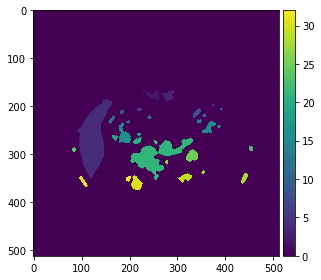

Max Area: 6016


In [86]:
ct_segm = (img < 140) & (img > 90)
ct_closing = morphology.closing(ct_segm, morphology.disk(3))
ct_opening = morphology.opening(ct_closing, morphology.disk(3))
label_img = measure.label(ct_opening, connectivity=2) #with res_img the solution is 493
n_labels = label_img.max()
# print(f"Number of labels: {n_labels}")
io.imshow(label_img)
io.show()

region_props = measure.regionprops(label_img)
max_area = 0
for i in range(n_labels):
    if region_props[i].area > max_area:
        max_area = region_props[i].area


print(f'Max Area: {max_area}')

NASA's Mars Perseverance rover has explored Mars since its landing at the beginning of 2021. To explore the surface of Mars, the rover uses a custom build camera. Now the rover has discovered three spectral peaks that might reflect different types of cosmic dust. Each dust spectra appears to follow a normal distribution. The parametric distributions of the three dust classes are N(7,2*2), N(15,5*5), and N(3,5*5).

NASA asks help to define the thresholds to perform robust classification.

They wish to perform a minimum distance classification of the three dust classes.

What signal thresholds should NASA use?

In [34]:
print(f'First Threshold would be {(3+7)/2}')
print(f'Second Threshold would be {(7+15)/2}')

First Threshold would be 5.0
Second Threshold would be 11.0


NASA's Mars Perseverance rover has explored Mars since its landing at the beginning of 2021. To explore the surface of Mars, the rover uses a custom build camera. Now the rover has discovered three spectral peaks that might reflect different types of cosmic dust. Each dust spectra appears to follow a normal distribution. The parametric distributions of the three dust classes are N(7,2*2), N(15,5*5), and N(3,5*5).

NASA asks help to define the thresholds to perform robust classification.

They wish to perform a parametric classification of the three dust classes.

What signal thresholds should NASA use?

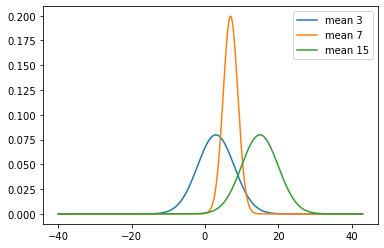

In [36]:
#%matplotlib notebook
# The solution is found using the inline matplotlib above to find the exact coordinates were they cross. 
# But they cross as around 4.28 and 10.32
x_axis = np.arange(-40, 43, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, 3, 5))
plt.plot(x_axis, norm.pdf(x_axis, 7, 2))
plt.plot(x_axis, norm.pdf(x_axis, 15, 5))
plt.legend(['mean 3', 'mean 7', 'mean 15'])
plt.show()
#Running this will create the plot

A teampalte matching is done on the image (from the exercise) with the template (also from the exercise).

The normalised cross correlation (NCC) between the image and the template is computed. What is the NCC in the marked pixel in the image?


In [64]:
data = np.array([[246, 204, 245, 173, 44],
                 [40, 36, 167, 193, 180],
                 [248, 108, 9, 189, 8],
                 [244, 234, 217, 100, 71],
                 [124, 202, 238, 167, 12]])
temp = np.array([[208, 233, 71],
                 [231, 161, 139],
                 [32, 25, 244]])

#print(data[2,3])
correlation = 0
length_of_image = 0
length_of_temp = 0
for i in range(1,4):
    for j in range(2,5):
        correlation = correlation + (data[i,j] * temp[i-1,j-2])
        length_of_image = length_of_image + np.power(data[i,j],2)
        length_of_temp = length_of_temp + np.power(temp[i-1,j-2],2)

#finally we have to take the square root of the lenght 
lenght_of_image = np.sqrt(length_of_image)
lenght_of_temp = np.sqrt(length_of_temp)
nnc = correlation / (lenght_of_image*lenght_of_temp)
print(f'The NNC value is: {nnc}')

The NNC value is: 0.6749205114127521


A company is making an automated system for fish inspection. They are using a camera with a CCD chip that measures 5.4 x 4.2 mm and that has a focal length of 10 mm. The camera takes photos that have dimensions 6480 x 5040 pixels and the camera is placed 110 cm from the fish, where a sharp image can be acquired of the fish.

How many pixels wide is a fish that has a length of 40 cm?

In [66]:
g = 110*10
G = 40*10
f = 10
b = f
B = b*G/g
# We know know how many mm of pixels are used. When dividing by the amount of mm that are available we find the ration. 
# From that we can times the ratio by the amount of pixels available and therefore get the amount of 
# pixels the fish will be 
B/4.2*5040


4363.636363636363

Two types of mushrooms (A and B) have been grown in Petri dishes. It appears that the mushrooms only can grow in specific positions in the Petri dish. You are asked to train a linear discriminant analysis (LDA) classifier to estimate the probability of a mushroom type growing at a given position in the Petri dish. It is a very timeconsuming experiment, so only five training examples for each type of mushroom were collected.

The training data are:

Class 0: Mushroom type A and their grow positions (x,y):
\
(1.00, 1.00)\
(2.20, -3.00)\
(3.50, -1.40)\
(3.70, -2.70)\
(5.00, 0)\
Class 1: Mushroom type B and their grow positions(x,y):\
( 0.10, 0.70)\
(0.22, -2.10)\
(0.35, -0.98)\
(0.37, -1.89)\
(0.50, 0)

What is the probability that the first training example of Mushroom Type A, with position (1.00, 1.00), actually belongs to class 1?

In [28]:


X = np.array([[1.00, 1.00],[2.20, -3.00],[3.50, -1.40],[3.70, -2.70],[5.00, 0],  #points for class 0 
              [0.10, 0.70],[0.22, -2.10],[0.35, -0.98],[0.37, -1.89],[0.50, 0]]) #points for class 1
T = np.array(np.zeros((5,1)))                    # 5 zeors for class 0
T = np.append(T,np.array(np.ones((5,1))),axis=0) # 5 ones for class 1

W = LDA(X,T)
print(W)
# The point that is being used for the probability
Xall= np.c_[1, 1]
Y = np.c_[np.ones((len(Xall), 1)), Xall] @ W.T   # The general equation        
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y),1)[:, np.newaxis], 0, 1) #Calculating the prob       
print(f'Probability of class 0 and 1: {PosteriorProb}')  



[[-4.80305983  2.55374595 -0.29039981]
 [-0.87980561  0.18986568 -0.36866304]]
Probability of class 0 and 1: [[0.18525971 0.81474029]]


# Exam May 2022

#### Page 2
A Hough transform has been performed on the image with the points seen here:\
The line that is parameterized with rho = 10 and theta = 0o passes through how many points?

In [4]:
# The formular for the hough transform is rho = xcos(theta) + ysin(theta). 
# we know that theta = 0 and rho = 10 so we get the equation 
# 10 = x, so it will cut through all the point where this is true which is 1 point 

Several lines have been found in the image and each have a set of [rho; theta] parameters. One of these lines passes two of the points seen in the image. Which line is that?

In [110]:

rho = np.array([-4.9, 0.0, 9.0, 9.9, 5.0])
theta = np.array([-45, -45, 90, 45, 0])*math.pi/180
points = np.array([[1,13],[2,9],[4,4],[5,2],[5,5],[5,12],[7,7],[10,4],[12,9],[13,9]])

for i in range(len(rho)):
    points_intercepted = 0
    for j in range(len(points)):
        x = points[j,0]
        y = points[j,1]
        if rho[i] == (x*math.cos(theta[i]) + y*math.sin(theta[i])):
            points_intercepted = points_intercepted + 1
    print(f'Points intercepted when rho is: {rho[i]} and theta is {theta[i]*180/math.pi} is: {points_intercepted}')
    

Points intercepted when rho is: -4.9 and theta is -45.0 is: 0
Points intercepted when rho is: 0.0 and theta is -45.0 is: 0
Points intercepted when rho is: 9.0 and theta is 90.0 is: 3
Points intercepted when rho is: 9.9 and theta is 45.0 is: 0
Points intercepted when rho is: 5.0 and theta is 0.0 is: 3


#### Page 3
Car and road image analysis

In order to create a system for smart cars, some photos of roads and cars should be analysed.

In order to create a system that can recognize brightly colored cars, a photo of a car is provided. The photo called car.png shows one car. The goal is compute the size of the car by finding the unique color of the car. First the photo is converted from the RGB color space to the HSV color space. Then a binary image is created by setting all the pixels that have an S component higher than 0.7 to foreground and the rest of the pixels to background. The values of the H and V components are ignored.

The binary image is morphologically eroded  using a disk-shaped structuring element with radius=6. The resulting image is morphologically dilated using a disk-shaped structuring element with radius=4.   

How many foreground pixels are there in the final image?

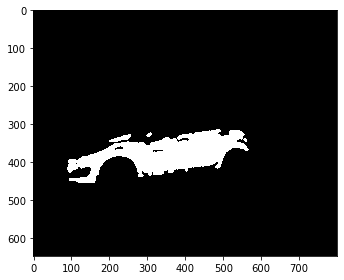

Amount of forground pixels 31365


In [6]:
car = io.imread("Data_2022_May/car.png")
#convert form rgb to hsv 
car_hsv = rgb2hsv(car)
s_comp = car_hsv[:,:,1]
car_segm = s_comp > 0.7 
car_eroded = morphology.erosion(car_segm, morphology.disk(6))
car_dilated = morphology.dilation(car_eroded, morphology.disk(4))
io.imshow(car_dilated)
io.show()
print(f'Amount of forground pixels {np.sum(car_dilated)}')

A photo has been taken of a piece of road with some parking lots marked with white lines. The goal is to recognize the white lines. 

First the photo is converted from the RGB color space to the HSV color space. Then a binary image is created by setting all the pixels that have a  V component higher than 0.9 to foreground and the rest of the pixels to background. The values of the H and S components are ignored.

The BLOBs in the binary image are found using 8-connectivity. The BLOBs that are connected to the image border are not removed. The area (in pixels) of all BLOBs are computed and all BLOBs that have an area less than a minimum area is removed. What is this minimum area if the result should be that there is only two BLOBs remaining and that the result looks like this image:

In [108]:
road = io.imread("Data_2022_May/road.png")
#convert form rgb to hsv 
road_hsv = rgb2hsv(road)
v_comp = road_hsv[:,:,2]
road_segm = v_comp > 0.9 
# here we don't clear the boarder as it say ARE NOT REMOVED!
#road_c_b = segmentation.clear_border(road_segm)

#finding amount of blobs in the image
label_img = measure.label(road_segm, connectivity=2) 
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

region_props = measure.regionprops(label_img)
min_area = [13021, 1047, 44, 5123, 57]
# max_area = 4000


for k in range(5):
    j = 0
    for i in range(n_labels):
#         print(region_props[i].area)
        if region_props[i].area >= min_area[k]:
            #print("Area", region_props[i].area)
            #print("Perimeter", region_props[i].perimeter)
            j = j + 1
    print(f'Amount of Blobs when the minimum area is {min_area[k]}: {j}')

Number of labels: 190
Amount of Blobs when the minimum area is 13021: 0
Amount of Blobs when the minimum area is 1047: 2
Amount of Blobs when the minimum area is 44: 3
Amount of Blobs when the minimum area is 5123: 1
Amount of Blobs when the minimum area is 57: 3


#### Page 4
Aorta analysis
#### question 1
A doctor would like to measure the size of the aorta in healthy patients. The aorta is the largest artery in the human body and can be seen as the circle-like structure here:

To develop an algorithm, CT scans with the aorta have been acquired. One of these scans is stored as a DICOM file and one slice is stored as a DICOM file called 1-442.dcm.

To be able to see the difference between the liver and the aorta, an expert has marked a part of the liver and a part of the aorta in the DICOM image. The markings are stored as masks in AortaROI.png and LiverROI.png. By using the DICOM image and the mask images, the grey-values representing the aorta and the liver can be extracted. 

An optimal grey-value threshold between the aorta and liver is computed using a parametric classifier. What is this threshold?
#### question 2 
An expert has marked the aorta in the scan and the marking is stored as a mask in (AortaROI.png). By using the DICOM image and the mask image, grey-values representing the blood in the aorta can be extracted.

In order to analyze the blood flow in the patient, the average and standard deviation of the grey-values of the blood are computed. They are?
#### question 3 
A threshold is set in the image, so all pixels with a value higher than T=90 are set to foreground (1) and the rest of the pixel to background(0).\
A BLOB analysis is then performed using 8-connectivity. BLOBs connected to the image border are removed. For each BLOB, the area (A) and perimeter (P) are computed. \
A measure of each BLOBs circularity (C) is computed by:\
$C=\frac{4\pi A}{P^2}$\
To find the aorta, only BLOBs with C > 0.95 and A > 200 pixels are kept.\
We know that a pixel on the scan has a physical side length of 0.75 millimeter.\
What is the area of the aorta in the scan?

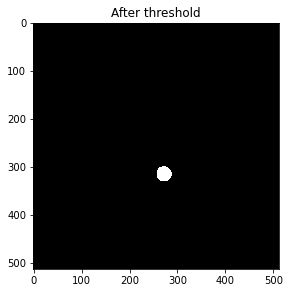

The arota has 783 pixels
area of arota (in mm) is: 440.4375


In [102]:
# first we read the dicom file
in_dir = "Data_2022_May/"
im_name = "1-442.dcm"
ds = dicom.dcmread(in_dir + im_name)
im = ds.pixel_array #type = unit 16
img = im.astype(float) #convert to float 

#how we convert [-1024,1024] to [0,255]
# norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
# norm_image = norm_image.astype(np.uint8)

aorta_roi = io.imread(in_dir + 'AortaROI.png')
liver_roi = io.imread(in_dir + "LiverROI.png")
# get values
aorta_mask, liver_mask = aorta_roi > 0, liver_roi > 0
aorta_values, liver_values = img[aorta_mask], img[liver_mask]
#bone_values, liver_values, spleen_values = norm_image[bone_mask], norm_image[liver_mask], norm_image[spleen_mask]
# compute mean and std 
mu_aorta, mu_liver = np.mean(aorta_values), np.mean(liver_values)
std_aorta, std_liver = np.std(aorta_values), np.std(liver_values)

# question 2
print("Aorta mean:",mu_aorta)
print("Liver mean:",mu_liver)
print("Aorta std:",std_aorta)
print("Liver std:",std_liver)
print((mu_aorta+mu_liver)/2)
# question 1 
#once the mean and std are found we use maple to equate the two gaussians and find the intercept 

# question 3 
img_segm = img>90

img_c_b = segmentation.clear_border(img_segm)
label_img = measure.label(img_c_b, connectivity=2) #with res_img the solution is 493
n_labels = label_img.max()
# print(f"Number of labels: {n_labels}")

region_props = measure.regionprops(label_img)
# min_area = 100
# min_perimeter = 500
C_thresh = 0.95 # C > 0.95 
A_thresh = 200  # A > 200 


# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
#     print(region.area, region.perimeter)
    if region.perimeter == 0:
        circularity = 0 
    else:
        circularity = ((2*math.sqrt(math.pi*region.area))/region.perimeter)
    # Find the areas that do not fit our criteria
#     print(circularity)
    if circularity < C_thresh or region.area < A_thresh:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0

io.imshow(i_area)
plt.title('After threshold')
io.show()
amount_of_pixels = np.sum(i_area)
print(f'The arota has {np.sum(i_area)} pixels')
area_1pixel = 0.75*0.75
print(f'area of arota (in mm) is: {amount_of_pixels*area_1pixel}')

#### Page 5
Image Compression

A grey scale photo has been acquired and the goal is to test different types of image compressions on the photo.
#### question 1
A threshold of 215 is used on the image, so all pixels above the threshold is set to foreground (1) and the rest is set to background (0). The image has a 0-based (x, y) coordinate system. The binary image is encoded using binary run-length coding. What is the result?

#### question 3


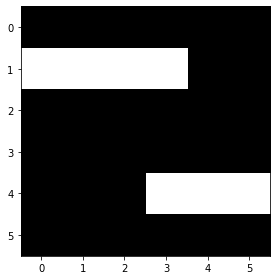

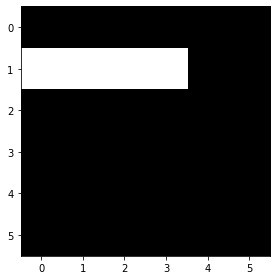

In [64]:
image = np.array([[208,208,208,202,202,202],
                  [231,231,231,231,193,193],
                  [193,193,193,167,167,167],
                  [167, 36, 36, 36, 36, 36],
                  [ 36, 40, 40,217,217,217],
                  [ 25, 25, 25, 25, 25, 25]])
#question 1 
img_bi1 = image > 215
io.imshow(img_bi1)
io.show()
# from this the encoded using binary run-length coding would be 
# [1;(0,3)], [4;(3,5)]

#question 2 we just compress the image to get, 
# 3, 208, 3, 202, 4, 231, 5, 193, 4, 167, 6, 36, 2, 40, 3, 217, 6, 25

# question 3
img_bi3 = image > 230
io.imshow(img_bi3)
io.show()
# from this the chain code would be 
# (0,1) (0,0,0,4,4,4)

#### Page 7 + 8 
Soccer player analysis

A soccer organization has collected player data for 2964 soccer players. For each player a score has been given for short passing, long passing, acceleration, sprint speed, agility and stamina. These measurements can be found in the soccer_data.txt file.\
A principal component analysis (PCA) has been performed on the soccer data.\
After the PCA, the soccer player data (short passing, long passing, acceleration, sprint speed, agility and stamina) are projected into PCA space. What is the maximum value of absolute values of all the projected player values?

In [129]:
soccor_data = np.loadtxt("Data_2022_May/soccer_data.txt", comments="%")
x = soccor_data

n_feat = x.shape[1]
n_obs = x.shape[0]
print(f"Number of features: {n_feat} and number of observations: {n_obs}")
short_pas = x[:, 0]
long_pas  = x[:, 1]
acc       = x[:, 2]
speed     = x[:, 3]
agility   = x[:, 4]
stamina   = x[:, 5]

mn = np.mean(x, axis=0)
data = x - mn
#print(data)

c_x = 1 / (n_obs - 1) * data.T @ data 
#print(c_x)
# # print(np.cov(data.T))
# print((abs(np.cov(data.T))))
V, PC = np.linalg.eig(c_x)
print(PC*(-1))
#print(V)

# # vec = [1,2,3,4]
# # vec_sum = [0]
# # for i in range(len(vec)):
# #     vec_sum.append(vec[i]+vec_sum[i])
# # #     print(vec[i], sum(vec_sum))
    
# # # print(vec_sum)

# v_norm = values / values.sum() * 100
# accumulated_pc = [0]
# for i in range(len(v_norm)):
#     accumulated_pc.append(v_norm[i]+accumulated_pc[i])

# # Question for page 9
# print(v_norm)
# print(accumulated_pc)
# plt.plot(v_norm)
# plt.xlabel('Principal component')
# plt.ylabel('Percent explained variance')
# plt.ylim([0, 100])
# plt.grid()
# plt.show()

Number of features: 6 and number of observations: 2964
[[ 0.42241068  0.43453898  0.20199772  0.23870964 -0.72992442  0.04658397]
 [ 0.35149403  0.62148775  0.2483475   0.03803401  0.65068164 -0.0607887 ]
 [ 0.45885855 -0.40731973  0.03268417  0.30478858  0.17683003  0.70590812]
 [ 0.41172981 -0.3780182  -0.09722708  0.43827543  0.08549467 -0.69190534]
 [ 0.44279154 -0.28343588  0.35461396 -0.76026609 -0.07076072 -0.12180754]
 [ 0.34911919  0.18917144 -0.87249528 -0.28033045 -0.0154425   0.04752168]]


Volcano analysis
A group of researchers aims to predict volcano eruptions. Using a new device, two values are measured and it is hoped that using these values it is possible to predict eruptions. Over a ten years period, values were measured for passive volcanoes and for erupting volcanoes. The measured values are:\
Passive volcanoes (class 1):\
(1.2, 1.1)\
(2.9, 0.4)\
(1.7, -2.7)\
(1.8, -0.3)\
(3.2, 1.3)\
(3.1, -0.9)\
Erupting volcanoes (class 2):\
(0.5, 1.7)\
(1.4, -2.1)\
(2.7, -0.8)\
(2.0, 0.5)\
To discriminate between the two classes, a linear discriminant analysis (LDA) has been performed on the above data.

#### Question 1 
The found LDA classifier is used on the training data. \
How many erupting volcanoes (class 2) are wrongly being classified as being passive?
#### Question 2 
The found LDA classifier is used on the training data. Some
erupting volcanoes (class 2) are wrongly being classified as being
passive. What are the probability values of these wrongly classified
volcanoes?

In [118]:
X = np.array([[1.2, 1.1],[2.9, 0.4],[1.7, -2.7],[1.8, -0.3],[3.2, 1.3],[3.1, -0.9], #points for class 0 
              [0.5, 1.7],[1.4, -2.1],[2.7, -0.8],[2.0, 0.5]]) #points for class 1

T = np.array(np.zeros((6,1)))                    # 5 zeors for class 0
T = np.append(T,np.array(np.ones((4,1))),axis=0) # 5 ones for class 1

W = LDA(X,T)
print(W)


# We test the four differnt class 2 points and see how they are being classified
Xall= np.c_[2.7,-0.8]
Y = np.c_[np.ones((len(Xall), 1)), Xall] @ W.T   # The general equation        
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y),1)[:, np.newaxis], 0, 1) #Calculating the prob       
print(f'Probability of class 1 and 2 for this point : {PosteriorProb}')  
# point 0.5, 1.7 has class 2 probability of 0.69 and is classified correctly  
# point 1.4,-2.1 has class 2 probability of 0.54 and is classified correctly 
# point 2.7,-0.8 has class 2 probability of 0.27 and is classified wrongly 
# point 2, 0.5   has class 2 probability of 0.39 and is classified wrongly 
# therefore 2 points are classified wrongly  


[[-3.9553119   2.97777621  0.05204909]
 [-2.66235025  2.11838433  0.01837208]]
Probability of class 1 and 2 for this point : [[0.73114799 0.26885201]]


A similarity transform (translation, rotation, and scaling) has been computed so that it aligns the moving points to the fixed points. The computed transform is applied to the play5.png photo.
After the transformation, a threshold is applied to the transformed image, so pixels below 180 are assigned to foreground (1) and the pixels above 180 are background (0). 

#### question 1
A reference image called reference.png is provided. The DICE score between the reference image and the transformed (and thresholded) image is computed. 

What is this DICE score?

#### question 2 
What is the Euclidean distance between the first landmark in the fixed
points and the first landmark in the moving points?

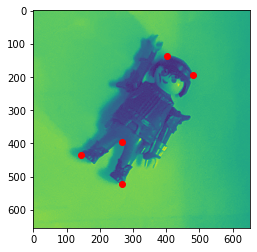

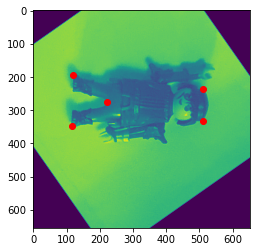

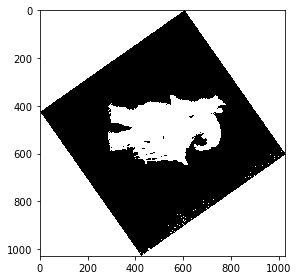

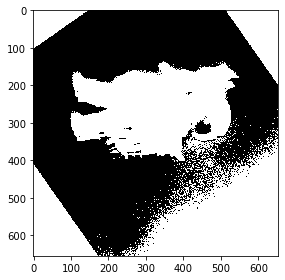

warped shape (655, 653)
ref shape  (1028, 1029)
warped min: 0.0 warped max: 255.0
ref min: 0 ref max: 255
ref shape  (655, 653)
ref min: 0.0 ref max: 255.0
Dice score is: 1.068227298986511
Euclidian distance between the first points is: 165.73470866719498


In [36]:
play5 = io.imread("Data_2022_May/play5.png")
ref = io.imread('Data_2022_May/reference.png')

moving_points = np.array([[534.505,236.838],[534.505,332.522],[83.517,198.565],
                         [245.541,277.025],[78.414,340.814]]) 
fixed_points = np.array([[402.396,136.762],[480.147,194.094],[144.008,434.418],
                          [267.312,397.505],[266.526,523.950]]) 

plt.imshow(play5)
plt.plot(fixed_points[:, 0], fixed_points[:, 1], '.r', markersize=12)
plt.show()

#We create the transformations here
tform = EuclideanTransform()
tform.estimate(fixed_points, moving_points)
#Transform the points
transform = matrix_transform(fixed_points, tform.params)
# Transform the images
warped = warp(play5, tform.inverse)
#Plot the transformed images and points
plt.imshow(warped)
plt.plot(transform[:, 0], transform[:, 1], '.r', markersize=12)
plt.show()

io.imshow(ref)
io.show()
warped = warped*(255/np.max(warped))
warped_segm = warped < 180 
io.imshow(warped_segm)
io.show()

from skimage.transform import rescale, resize

ref_resized = (resize(ref, (655, 653),anti_aliasing=True))*255

print("warped shape" ,warped.shape)
print("ref shape ", ref.shape)
print(f'warped min: {np.min(warped)} warped max: {np.max(warped)}')
print(f'ref min: {np.min(ref)} ref max: {np.max(ref)}')
print("ref shape ", ref_resized.shape)
print(f'ref min: {np.min(ref_resized)} ref max: {np.max(ref_resized)}')


# Since there is a size difference the prioblem is solved in matlab :) 
# dice_score = 1 - distance.dice(warped_segm.ravel(), ref_resized.ravel())
# print(f'Dice score is: {dice_score}')

# question 2- Euclidian distance betweent he forst point
moving_x = moving_points[0,0]
moving_y = moving_points[0,1]
fixed_x = fixed_points[0,0]
fixed_y = fixed_points[0,1]
print(f'Euclidian distance between the first points is: {np.sqrt(np.power((moving_x-fixed_x),2)+np.power((moving_y-fixed_y),2))}')